## Классификация изображений диабетической ретинопатии с использованием нейронных сетей

In [343]:
#!g1.1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import shutil

from sklearn.utils.random import sample_without_replacement
from sklearn.preprocessing import LabelBinarizer

sns.set('notebook', style='whitegrid', font_scale=1.3)
figsize = (15, 6)

Используется датасет со снимками глазного дна. Основная цель -- научить модель определять тяжесть диабетической ретинопатии по снимку.
В файле train.csv дана классификация снимков по следующим классам:

0. Normal
1. Mild
2. Moderate
3. Severe
4. Proliferative






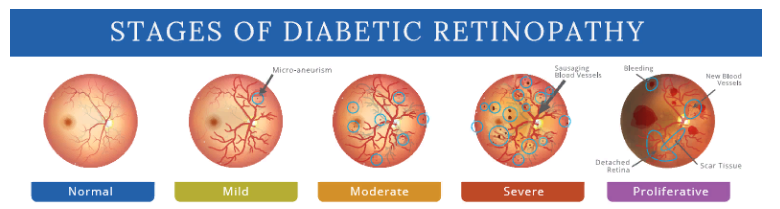

План предстоящей работы:

* Посмотрим на состав классов в данных (кого больше, кого меньше)
* Определим код для обучения модели
* Разобьем данные (изображения) на train/val/test
* Воспользуемся как сверточной нейронной сетью, написанной в библиотеке PyTorch, так и редобученной моделью ResNet
* Проведем трансформации изображений для того, чтобы выделить существенные детали и стандартизовать изображения

Diabetic Retinopathy dataset: https://drive.google.com/file/d/1y6UKa-3hHjtp7FK5ikAeHsqIThN0J70T/view?usp=sharing

Для начала скачаем датасет и распакуем данные.

In [ ]:
#!wget "drive.google.com/u/3/uc?id=1y6UKa-3hHjtp7FK5ikAeHsqIThN0J70T&export=download&confirm=yes" -O retinopathy_dataset.tar.gz
#!tar xzf retinopathy_dataset.tar.gz

In [721]:
#!g1.1
DATA_PATH = "C:\\Users\\Gleb1\\YandexDisk\\dataset\\experiment"

Разобьем `train` выборку на `train`, `val` и `test`', так что изображения будут лежать в отдельных папках на диске:

In [722]:
#!g1.1
# Папка со всеми данными / папка с картинами для тренировки
TRAIN_DIR = os.path.join(DATA_PATH, "train")

# Папка с данными для валидации
VAL_DIR = os.path.join(DATA_PATH, "val")
os.makedirs(VAL_DIR, exist_ok=True)

# Папка с данными для теста
TEST_DIR = os.path.join(DATA_PATH, "test")
os.makedirs(TEST_DIR, exist_ok=True)

In [723]:
#!g1.1
def create_dataset(FRAC, source_folder, destination_folder):
    '''
    Функция отбирает заданную долю FRAC от тренировочного датасета (source_folder) и переносит
    изображения в тестовый/валидационный датасет (destination_folder)
    '''
    images_filename = sorted(os.listdir(source_folder))
    
    num_images = len(images_filename)
    num_val = int(num_images * FRAC)
    indices = sample_without_replacement(num_images, num_val, random_state=42)
    val_images = np.take(images_filename, indices)

    # Сохраняем валидационную выборку
    for image_filename in val_images:
        source = os.path.join(source_folder, image_filename)
        destination = os.path.join(destination_folder, image_filename)
        shutil.copy(source, destination)
        os.remove(source)
    
    return (num_images, num_val)

In [724]:
#!g1.1
# Доля данных в валидации
VAL_FRAC = 0.3
# Доля данных в тесте
TEST_FRAC = 0.2

_, num_test         = create_dataset(TEST_FRAC, TRAIN_DIR, TEST_DIR)
num_images, num_val = create_dataset(VAL_FRAC, TRAIN_DIR, VAL_DIR)

print(f'train images = {num_images - num_val} | val images = {num_val}| test images = {num_test}')

train images = 4480 | val images = 1920| test images = 1600


Разобьем изображения на классы. Структура приведена в комментариях

In [725]:
def create_classes(source_folder):
    '''
    Чтобы использовать datasets.ImageFolder, необходимо предерживаться структуры:
    ├── train
    │   ├── class1
    |      ├── 1.jpg
    │      ├── 2.jpg
    │   ├── class2
    |      ├── 1.jpg
    │      ├── 2.jpg
    Данная функция распределяет объекты по классам согласно labels.csv
    '''
    for class_name in range(5):
        os.makedirs(os.path.join(source_folder, str(class_name)), exist_ok=True)
        
    images_filename = sorted(os.listdir(source_folder))
    
    
    for image_filename in images_filename:
        if os.path.isfile(os.path.join(source_folder, image_filename)):
            name = image_filename.split('.')[0]
            image_class = int(df[df['image'] == name]['level'])

            source = os.path.join(source_folder, image_filename)
            destination = os.path.join(source_folder,  str(image_class) , image_filename)
            #print(destination)
            shutil.copy(source, destination)
            os.remove(source)
        
create_classes(TRAIN_DIR)
create_classes(TEST_DIR)
create_classes(VAL_DIR)

## Подготовка датасета с помощью `ImageFolder`

In [726]:
#!g1.1
import torch
from torch import nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms, datasets
from PIL import Image
#размер каждого изображения до обработки (3, 512, 512)=(channels, img_shape, img_shape)
#после обработки остается только центральный квадрат в 2 раза меньше
img_shape = 512

In [727]:
#!g1.1
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=transforms.Compose([transforms.Resize((img_shape, img_shape)),
                                                                              transforms.ToTensor()]))
#transforms.Resize((img_shape, img_shape))
#задаем размер батча и делаем генератор на основе изображений из двух каталогов
batch_size = 6

train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Посмотрим на несколько изображений в обучающем датасете

In [728]:
'''
Функция для отрисовки одного батча
'''
def plot_train_batch(images, labels, title = 'Original'):
    plt.figure(figsize = (15,3))
    plt.suptitle('Train Batch:'+title)
    for i in range(batch_size):
        plt.subplot(1, 6, i+1)
        plt.title(labels[i])
        plt.imshow(images[i].numpy().T)
        plt.axis("off");

Зафиксируем набор из 6 изображений

In [729]:
images, labels = next(iter(train_batch_gen))

Выполним преобразования с помощью `torchvision.transforms`.
Размытие изображений здесь не нужно, поскольку можно потерять существенные различия между классами. В работе я вырезаю центральную часть и делаю случайные горизонтальные отражения.

In [730]:
from torchvision.transforms import v2

transformation = v2.Compose([
    #v2.RandomResizedCrop(size=(img_shape, img_shape), antialias=True), #img_shape = 512
    v2.CenterCrop(size=400),
    v2.Resize(size=256, antialias=True),
    v2.Grayscale(1),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.uint8, scale=True)
    #torchvision.transforms.ToTensor()
])

Преобразование с использованием GaussianBlur взято из статьи:
Image preprocessing-based ensemble deep learning classification
of diabetic retinopathy - https://www.researchgate.net/publication/375671437_Image_preprocessing-based_ensemble_deep_learning_classification_of_diabetic_retinopathy

In [731]:
transform_1 = transforms.Lambda(lambda y: 4*(y - transforms.functional.gaussian_blur(y, kernel_size=(11,11), sigma=(11, 11)))+128)
transform_2 = v2.RandomAutocontrast(p=1)
transform_3 = v2.RandomEqualize(p=1)

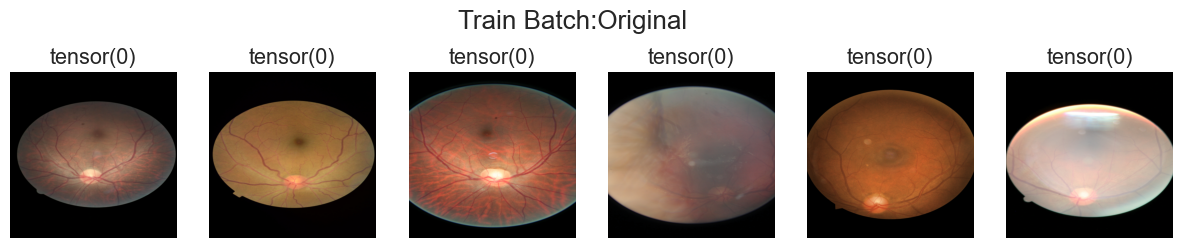

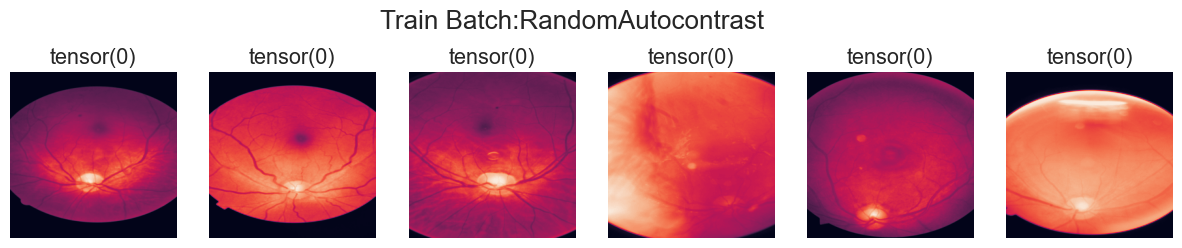

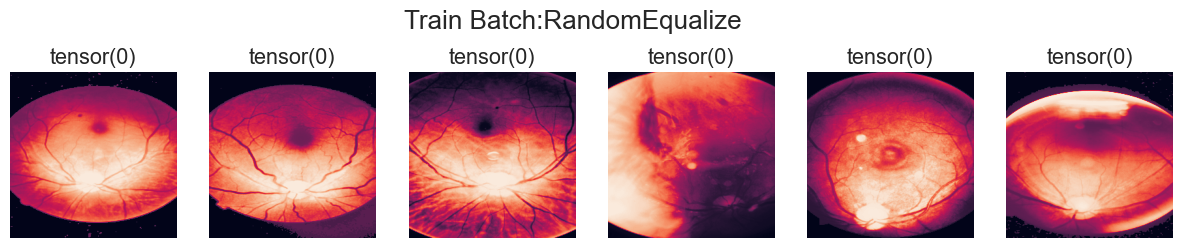

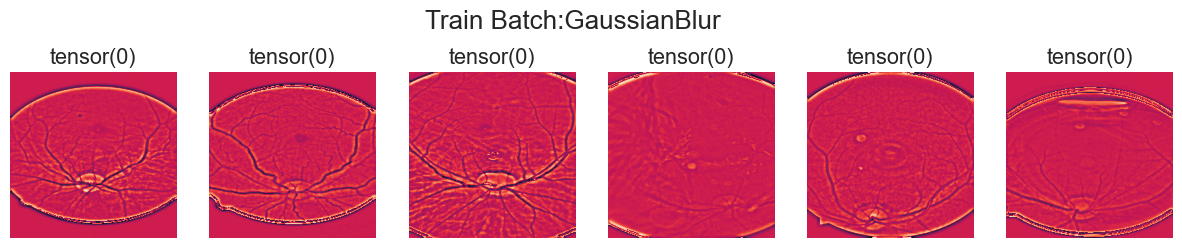

In [732]:
#!g1.1
cropped = transformation(images)
plot_train_batch(images, labels, title = 'Original');
plot_train_batch(transform_2(cropped), labels, title = 'RandomAutocontrast');
plot_train_batch(transform_3(cropped), labels, title = 'RandomEqualize');
plot_train_batch(transform_1(cropped), labels, title = 'GaussianBlur');

In [733]:
transformation = v2.Compose([
    v2.CenterCrop(size=400),
    v2.Resize(size=256, antialias=True),
    v2.Grayscale(3),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.uint8, scale=True),
    v2.RandomEqualize(p=1),
    torchvision.transforms.ToTensor()
])
transformation_test = v2.Compose([
    v2.CenterCrop(size=400),
    v2.Resize(size=256, antialias=True),
    v2.Grayscale(3),
    v2.ToDtype(torch.uint8, scale=True),
    v2.RandomEqualize(p=1),
    torchvision.transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=transformation)
val_dataset = datasets.ImageFolder(VAL_DIR, transform=transformation_test)
test_dataset = datasets.ImageFolder(TEST_DIR, transform=transformation_test)

#задаем размер батча и делаем генератор на основе изображений из двух каталогов
batch_size = 6

train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_batch_gen = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Разведочный анализ данных (exploratory data analysis, EDA)

Первый взгляд на данные без предобработки

In [2]:
df = pd.read_csv("C:\\Users\\Gleb1\\YandexDisk\\dataset\\labels.csv")
df.head()

NameError: name 'pd' is not defined

Состав классов. Видно, что наблюдается дисбаланс классов. Поэтому при подсчете метрики качества классификации необходимо будет сделать поправку, введя весовые коэффициенты.

Больше всего объектов класса `Normal`, а меньше - `Proliferate`

In [735]:
'''
Это данные взяты из таблицы
'''
df.level.map({0: 'Normal', 1 : 'Mild', 2: 'Moderate',\
              3: 'Severe', 4: 'Proliferative'}).value_counts()

Normal           5912
Moderate         1196
Mild              530
Severe            205
Proliferative     157
Name: level, dtype: int64

In [736]:
'''
Здесь веса подсчитаны не по всему набору данных, а только для тренировочного набора данных
'''
train_counts = torch.unique(torch.tensor(train_dataset.targets), return_counts=True)[1]
train_weights = 1./train_counts
train_weights # веса в лосс функцию

tensor([0.0003, 0.0034, 0.0015, 0.0083, 0.0111])

Посмотрим на несколько изображений. Сразу можно заметить, что:
1. Для некоторых образцов в датасете представлен как левый, так и правый глаз. А для некоторых только один. Кажется, что нужно следить за тем, чтобы разные изображения одного пациента вошли одновременно либо в train, либо в test, либо в val.
2. Изображения не симметричны, эта ассиметричность несет лишнюю информацию для предсказания классов.
2. Некоторые изображения засвечены, а некоторые наоборот отсутствуют, так что видно только черный фон.
3. Глазное дно на снимках разного размера и по-разному обрезаны границы у изображений.
4. Все картинки имеют разное разрешение - для применения CNN потребуется оставить один размер

## Вспомогательные функции
Объявим функции для отрисовки лосса и метрик во время обучения

In [737]:
def plot_learning_curves(history):
    '''
    Функция для вывода лосса и метрики во время обучения.

    :param history: (dict)
        accuracy и loss на обучении и валидации
    '''
    # sns.set_style(style='whitegrid')
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

Подгрузим вспомогательные библиотеки

In [738]:
import time
from tqdm.notebook import tqdm
from collections import defaultdict

from IPython.display import clear_output
from sklearn.metrics import f1_score

In [739]:
def train(
    model,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=50
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param val_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох

    :return: обученная модель
    :return: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        start_time = time.time()

        # Устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in tqdm(train_batch_gen):
            # Обучаемся на батче (одна "итерация" обучения нейросети)
            X_batch = X_batch.to(device)

            y_batch = y_batch.to(device)
            # Логиты на выходе модели
            logits = model(X_batch)


            # Подсчитываем лосс
            loss = criterion(logits, y_batch.long().to(device))

            # Обратный проход
            loss.backward()
            # Шаг градиента
            optimizer.step()
            # Зануляем градиенты
            optimizer.zero_grad()

            # Сохраяняем лоссы и точность на трейне
            train_loss += loss.detach().cpu().numpy()
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += f1_score(y_batch.cpu().numpy(), y_pred, average='macro')

        # Подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        # Устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # Полный проход по валидации
        with torch.no_grad():
          for X_batch, y_batch in tqdm(val_batch_gen):
              X_batch = X_batch.to(device)
              y_batch = y_batch.to(device)

              # Логиты, полученные моделью
              logits = model(X_batch)

              # Лосс на валидации
              loss = criterion(logits, y_batch.long().to(device))

              # Сохраяняем лоссы и точность на валидации
              val_loss += loss.detach().cpu().numpy()
              y_pred = logits.max(1)[1].detach().cpu().numpy()
              val_acc += f1_score(y_batch.cpu().numpy(), y_pred, average='macro')

          # Подсчитываем лоссы и сохраням в "историю"
          val_loss /= len(val_batch_gen)
          val_acc /= len(val_batch_gen)
          history['loss']['val'].append(val_loss)
          history['acc']['val'].append(val_acc)

          clear_output()

          # Печатаем результаты после каждой эпохи
          print("Epoch {} of {} took {:.3f}s".format(
              epoch + 1, num_epochs, time.time() - start_time))
          print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
          print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
          print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
          print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

          plot_learning_curves(history)

    return model, history

## Обучение CNN и эксперименты


In [740]:
#!g1.1
def conv_bn_relu(in_channels, out_channels, kernel=3, stride=1, padding=1):
    net = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 
                  kernel_size=kernel, stride=stride, padding=padding),
        nn.MaxPool2d(2),
        nn.BatchNorm2d(num_features=out_channels),
        nn.Dropout(p=0.5),
        nn.ReLU(inplace=True)
    )
    return net

 Создаем класс сверточной нейронной сети

In [741]:
#!g1.1
# Модель
class CNN(nn.Module):
    def __init__(self):
        '''
        Здесь объявляем все слои, которые будем использовать
        '''
        super(CNN, self).__init__()

        self.layer_1 = conv_bn_relu(in_channels = 3, out_channels = 64, kernel=3, stride=2, padding=1)
        self.layer_2 = conv_bn_relu(in_channels = 64, out_channels = 128, kernel=3, stride=2, padding=1)
        
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(32768, 5)  # логиты (logits) для 5 классов
        
        
    def forward(self, x):
        '''
        Здесь пишем в коде, в каком порядке какой слой будет применяться
        '''
        net1 = self.layer_1(x)
        net2 = self.layer_2(net1)
        net = self.linear( self.flatten(net2) ) 
        return net

Подгрузим библиотеки для визуализации архитектуры сети

In [246]:
#!g1.1
%pip install torchinfo
from torchinfo import summary

Note: you may need to restart the kernel to use updated packages.


Посмотрим на архитектуру, которую мы сделали

In [259]:
#!g1.1
#device = 'cuda:0'
device = 'cpu'
model = CNN().to(device)
summary(model.to(device), (6, 3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [6, 5]                    --
├─Sequential: 1-1                        [6, 64, 64, 64]           --
│    └─Conv2d: 2-1                       [6, 64, 128, 128]         1,792
│    └─MaxPool2d: 2-2                    [6, 64, 64, 64]           --
│    └─BatchNorm2d: 2-3                  [6, 64, 64, 64]           128
│    └─Dropout: 2-4                      [6, 64, 64, 64]           --
│    └─ReLU: 2-5                         [6, 64, 64, 64]           --
├─Sequential: 1-2                        [6, 128, 16, 16]          --
│    └─Conv2d: 2-6                       [6, 128, 32, 32]          73,856
│    └─MaxPool2d: 2-7                    [6, 128, 16, 16]          --
│    └─BatchNorm2d: 2-8                  [6, 128, 16, 16]          256
│    └─Dropout: 2-9                      [6, 128, 16, 16]          --
│    └─ReLU: 2-10                        [6, 128, 16, 16]          --
├─Flat

Обучим модель
Используем кросс-энтропийный критерий, а также оптимизатор Adam

Epoch 20 of 20 took 56.512s
  training loss (in-iteration): 	1.174834
  validation loss (in-iteration): 	2.489909
  training accuracy: 			56.40 %
  validation accuracy: 			20.46 %


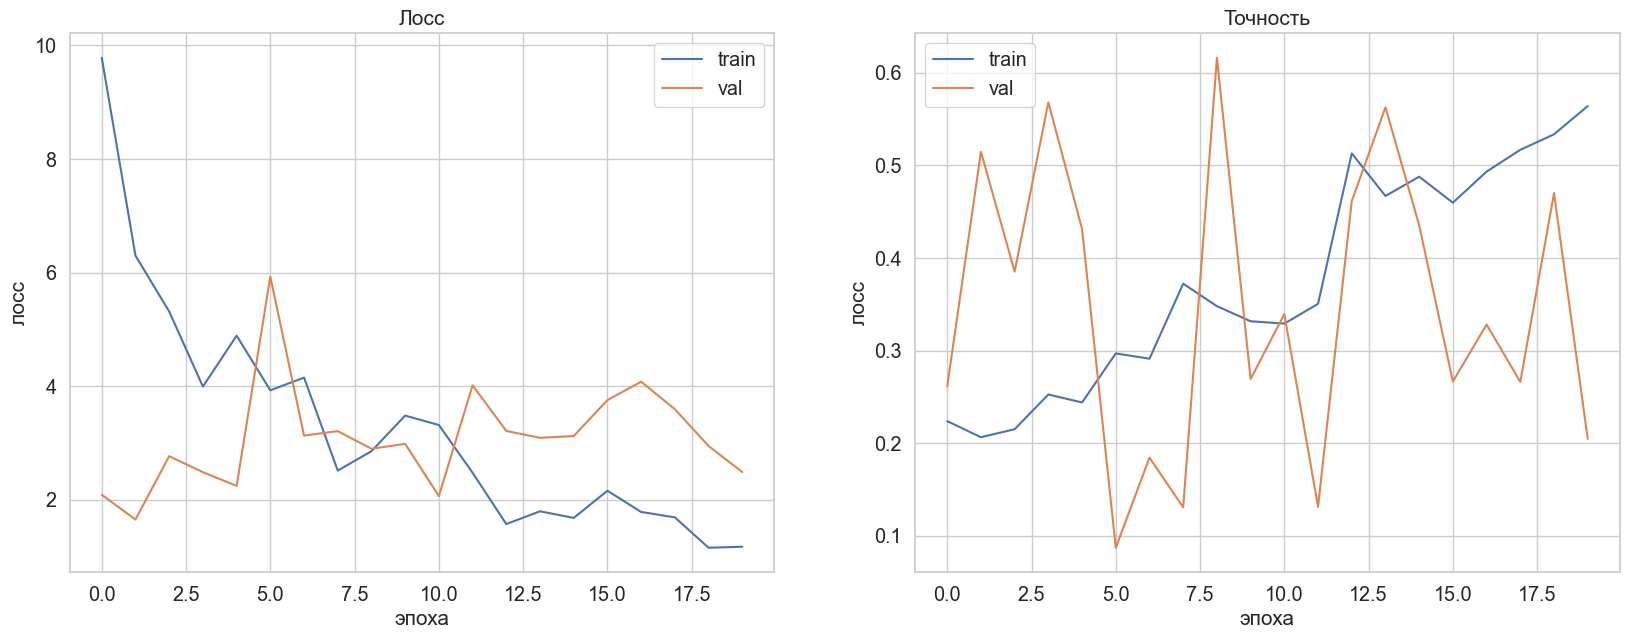

In [716]:
torch.manual_seed(2)
device = 'cpu'
model = CNN().to(device)
criterion = nn.CrossEntropyLoss(weight=train_weights.to(device), reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs=20

model, history = train(
    model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=num_epochs
)

Epoch 20 of 20 took 56.577s
  training loss (in-iteration): 	1.179677
  validation loss (in-iteration): 	3.854567
  training accuracy: 			52.01 %
  validation accuracy: 			22.92 %


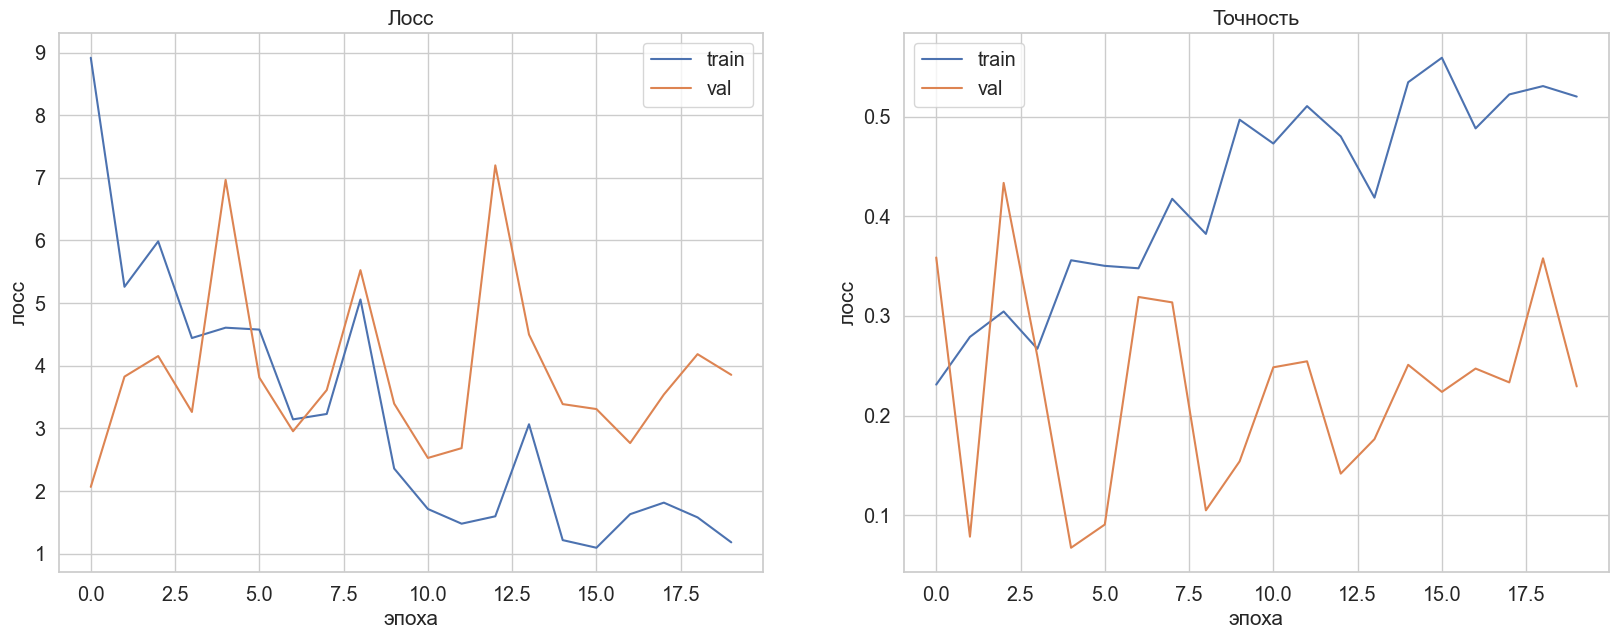

In [260]:
torch.manual_seed(2)
device = 'cpu'
model = CNN().to(device)
criterion = nn.CrossEntropyLoss(weight=train_weights.to(device), reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs=20

model, history = train(
    model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=num_epochs
)

### Первая попытка
Один слой сверточной нейронной сети.
Использовались данные без предобработки

Epoch 20 of 20 took 12.828s
  training loss (in-iteration): 	1.117994
  validation loss (in-iteration): 	7.035511
  training accuracy: 			70.36 %
  validation accuracy: 			23.48 %


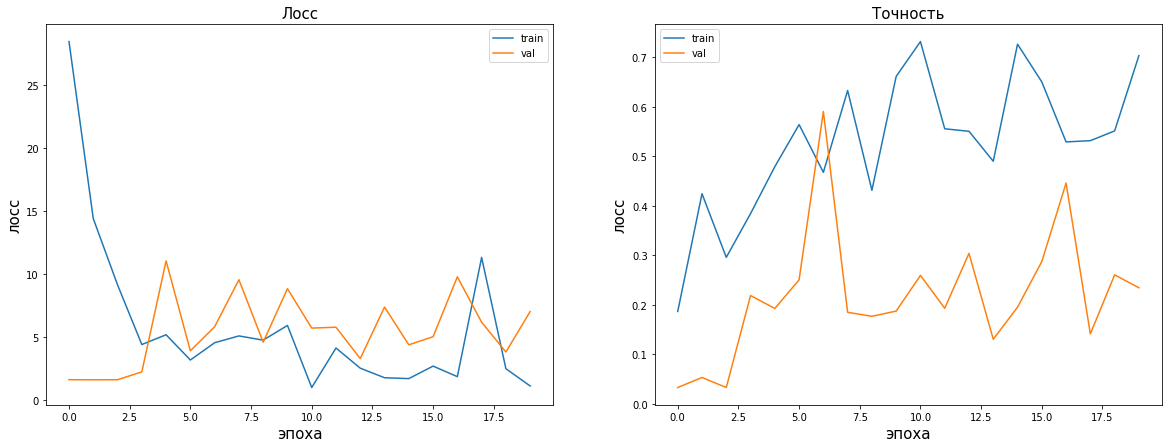

In [209]:
#!g1.1
torch.manual_seed(2)
device = 'cuda:0'
model = SimpleConvNet().to(device)
criterion = nn.CrossEntropyLoss(weight=train_weights.to(device), reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs=20

model, history = train(
    model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=num_epochs
)

## Использование предобученных нейронных сетей

In [717]:
train_counts = torch.unique(torch.tensor(train_dataset.targets), return_counts=True)[1]
train_weights = 1./train_counts
train_weights # веса в лосс функцию

tensor([0.0042, 0.0385, 0.0263, 0.1250, 0.2000])

In [719]:
from torchvision.models import resnet18, ResNet18_Weights
clf_model = resnet18(weights=ResNet18_Weights.DEFAULT).to(device) # загрузите предобученную resnet18

# "замораживаем" все веса всех слоев
for param in clf_model.parameters():
  param.requires_grad = False
  # ваш код

# переоопределим последний классификационный слой
clf_model.fc = nn.Linear(in_features=512, out_features=5, bias=True)# определите голову сети
clf_model = clf_model.to(device)

Epoch 4 of 5 took 77.118s
  training loss (in-iteration): 	1.450328
  validation loss (in-iteration): 	1.096168
  training accuracy: 			35.31 %
  validation accuracy: 			55.32 %


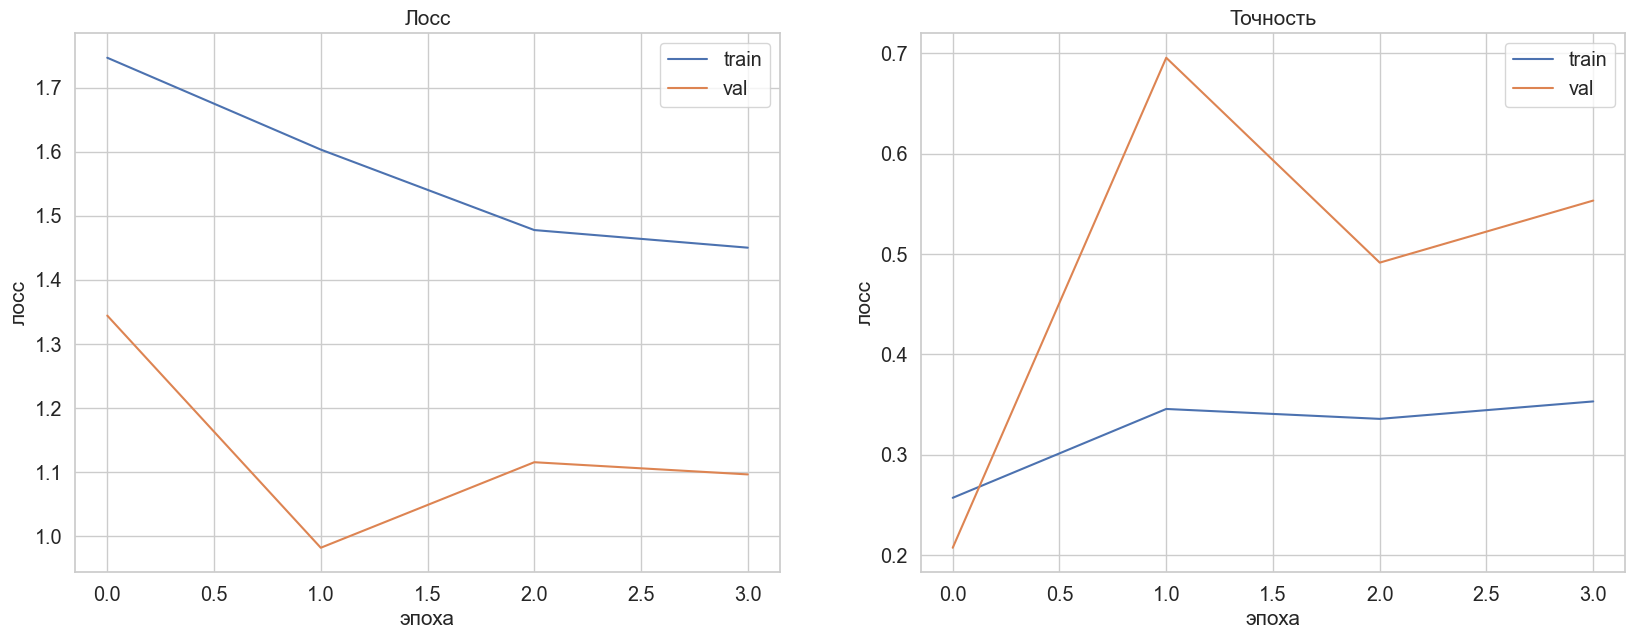

  0%|          | 0/53 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [720]:
import sklearn.metrics
lr = 1e-3
n_epochs = 5

criterion = nn.CrossEntropyLoss(weight=train_weights.to(device), reduction='mean')
optimizer = torch.optim.Adam(clf_model.parameters(),
                             lr=lr)

model, history = train(
    clf_model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=n_epochs
)

In [ ]:
import sklearn.metrics
lr = 1e-3
n_epochs = 5

criterion = nn.CrossEntropyLoss(weight=train_weights.to(device), reduction='mean')
optimizer = torch.optim.Adam(clf_model.parameters(),
                             lr=lr)

model, history = train(
    clf_model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=n_epochs
)